# Local Dependence

In [1]:
import numpy as np
import sys
sys.path.insert(1, '../../')
from SPD_SURE_pytorch import *
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns
import pandas as pd
from plotnine import *
from plotnine.data import mpg
import multiprocessing
from joblib import Parallel, delayed
from scipy.stats import invwishart

In [2]:
def FM_smooth(X, k):
    # X is an array of p independent N x N SPD matrices
    # k is the smooth parameter, i.e., compute the FM for every consecutive k matrices
    p, N = X.shape[0:2]
    Y = np.zeros((p - k + 1, N, N))
    for i in range(p-k+1):
        Y[i] = FM_logE(X[i:i+k])
    return Y

In [18]:
def exp_dep(ran_seed):
    p = 100
    N = 3
    q = int(N*(N+1)/2)
    lam = 50
    mu = np.eye(N)
    nu = 30
    Psi = np.eye(q)
    n = 10
    
    k_vec = np.array([1,2,3,4,5,6,7,8,9,10])
    
    
    loss_SURE = np.zeros(len(k_vec))
    loss_SURE_full = np.zeros(len(k_vec))
    loss_MLE = np.zeros(len(k_vec))
    
    for i, k in enumerate(k_vec):
        p_ext = p + k - 1
        np.random.seed(ran_seed)
        
        # generate independent SPD matrices
        Sigma = invwishart.rvs(nu, Psi, size = p_ext)
        M = np.zeros((p_ext, N, N))
        M = np.array([SPD_normal(1, mu, Sigma[i]/lam) for i in range(p_ext)])
        Y = np.array([SPD_normal(n, M[i], Sigma[i]) for i in range(p_ext)])
        
        # compute the moving average to make the array dependent
        M_dep = FM_smooth(M, k)
        X = np.array([FM_smooth(Y[:,j], k) for j in range(n)])
        X = X.transpose((1,0,2,3))
        
        M_logE = np.array([FM_logE(X[i]) for i in range(p)])    
        S_logE = (n-1)*np.array([cov_logE(X[i]) for i in range(p)])
        S_eigval = np.linalg.eigh(S_logE)[0]
        
        _, _, M_SURE = SURE_const(M_logE, np.mean(S_eigval, axis = 1)/(n*(n-1)), verbose = False)
        
        _, _, _, _, M_SURE_full, Sig_SURE_full = SURE_full(M_logE, S_logE, n, verbose = False)
        
        loss_MLE[i] = loss(M_logE, M_dep)
        loss_SURE[i] = loss(M_SURE, M_dep)
        loss_SURE_full[i] = loss(M_SURE_full, M_dep)
        
        
    risk = pd.DataFrame(list(zip(k_vec, loss_MLE, loss_SURE, loss_SURE_full)),
                    columns =['k', 'MLE', 'SURE', 'SURE_full'])
    return risk.values



In [19]:
seed = 2022
num_cores = -1
m = 100

results = Parallel(n_jobs=num_cores)(delayed(exp_dep)(seed + i) for i in range(m))



/Users/chyang/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 4 in image.
/Users/chyang/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: local_dependence.pdf


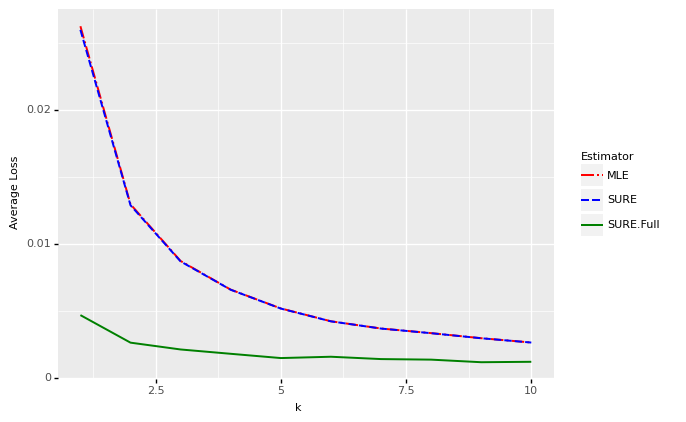

<ggplot: (8790204235054)>

In [21]:
risk = pd.DataFrame(np.mean(np.array(results), axis = 0), columns =['k', 'MLE', 'SURE', 'SURE_full'])

risk = pd.melt(risk, ['k'], var_name='Estimator', value_name='risk')
fig = (ggplot(risk)
    + aes(x='k', y='risk', color='Estimator', linetype='Estimator')
    + geom_line(size = 0.8)
    + xlab('k')
    + ylab('Average Loss')
    + scale_color_manual(labels = ['MLE', 'SURE', 'SURE.Full'], 
                       values = ['red', 'blue', 'green'])
    + scale_linetype_manual(labels = ['MLE', 'SURE', 'SURE.Full'], 
                          values = ['dashdot','dashed','solid'])
    + theme(axis_title=element_text(size=8), 
          axis_text=element_text(size=8),
          legend_title=element_text(size=8),
          legend_text=element_text(size=8),
          strip_text=element_text(size=8))
    #+ ggtitle(r'$\mu=diag(2,0.5,0.5)$, $\Psi = I_6$, $\lambda = 10$, $\nu=15$')
    )

fig.save('local_dependence.pdf', dpi = 320, width = 6, height = 4, units="in")
fig